# Logistic Classifier
### Importing data:

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
violations = pd.read_pickle('data/violations.pkl')

In [3]:
violations['rating'] = violations.rating.fillna(5)
violations = violations[violations.delay > 21]
violations = violations.drop(['latitude','longitude','reviews','tips'], axis=1)

### Cross-validated hyperparameter tuning:

In [4]:
from sklearn.cross_validation import train_test_split
X = violations.iloc[:,6:52]
y = (violations['*'] + violations['**'] + violations['***'] > 0).values.astype(np.int)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
gs = GridSearchCV(
        estimator = LogisticRegression(),
        param_grid = {'C':np.arange(36, 38, .01)},
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
gs.best_params_

{'C': 37.119999999999777}

### Evaluation:
* Accuracies on training and test sets
* ROC curve and its AUC
* Precision-recall curve and its AUC
* Learning curve

In [6]:
clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

(0.82559440559440556, 0.81375838926174493)

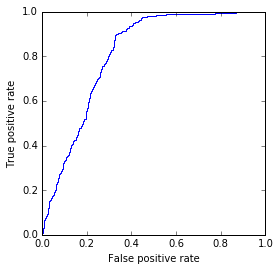

0.81374810482997617

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (4, 4)
xroc, yroc, _ = roc_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
auc(xroc,yroc)

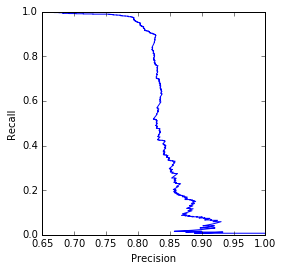

0.84312584390446155

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()
average_precision_score(ytest, clf.predict_proba(Xtest)[:,1])

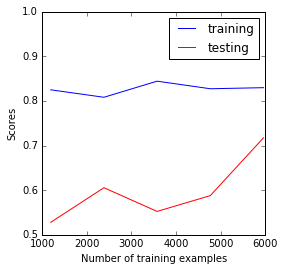

In [9]:
from sklearn.learning_curve import learning_curve
train_size, train_score, test_score = learning_curve(
    clf, 
    X, 
    y, 
    n_jobs = -1,
    train_sizes = (.2, .4, .6, .8, 1.0)
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Scores')
plt.show()